In [1]:
import torch 
import torch.nn.functional as F
from torch import nn
from collections import OrderedDict
from transformer import MultiHeadedAttention, EncoderLayer, PositionalEncoder, DecoderLayer, Transformer

In [2]:
# component testing against pytorch implementations
# 1. test that our multihead attention implementation is correct (at least for encoder without masking)

# test 1 - with 1 head 
pt_attn = nn.MultiheadAttention(embed_dim=512, num_heads=1, bias=False, batch_first = True) # pytorch implementation
input = torch.rand((1, 8, 512))
pt_attn_output, pt_attn_weights = pt_attn(input, input, input)

my_attn = MultiHeadedAttention(512, 512, 512, 1, use_enc_embed=False, use_mask=False, mask=None) # my implementation
my_attn.attn[0].W_Q = nn.Parameter(pt_attn.in_proj_weight[:512, :].T) # use same parameter values
my_attn.attn[0].W_K = nn.Parameter(pt_attn.in_proj_weight[512:2*512, :].T)
my_attn.attn[0].W_V = nn.Parameter(pt_attn.in_proj_weight[2*512:3*512, :].T)
my_attn.W_O = nn.Parameter(pt_attn.out_proj.weight.T)
my_attn_output = my_attn(input)

assert(torch.allclose(my_attn_output, pt_attn_output, atol=1e-5, rtol=1e-5))

# test 2 - with 2 heads 
pt_attn = nn.MultiheadAttention(embed_dim=512, num_heads=2, bias=False, batch_first = True) # pytorch implementation
input = torch.rand((1, 8, 512))
pt_attn_output, pt_attn_weights = pt_attn(input, input, input)

my_attn = MultiHeadedAttention(512, 256, 256, 2, use_enc_embed=False, use_mask=False, mask=None) # my implementation

my_attn.attn[0].W_Q = nn.Parameter(pt_attn.in_proj_weight[:256, :].T) # use same parameter values
my_attn.attn[1].W_Q = nn.Parameter(pt_attn.in_proj_weight[256:2*256, :].T)

my_attn.attn[0].W_K = nn.Parameter(pt_attn.in_proj_weight[2*256:3*256, :].T)
my_attn.attn[1].W_K = nn.Parameter(pt_attn.in_proj_weight[3*256:4*256, :].T) # use same parameter values

my_attn.attn[0].W_V = nn.Parameter(pt_attn.in_proj_weight[4*256:5*256, :].T)
my_attn.attn[1].W_V = nn.Parameter(pt_attn.in_proj_weight[5*256:6*256, :].T)

my_attn.W_O = nn.Parameter(pt_attn.out_proj.weight.T)
my_attn_output = my_attn(input)

assert(torch.allclose(my_attn_output, pt_attn_output, atol=1e-3, rtol=1e-3))

/Users/ethantrepka/Documents/paper-implementations/vaswani2017_attention/transformer.py:69: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  pos[:, 2*i] = torch.sin(torch.range(start=0, end=self.d_model-1, step=1)/(10000 ** (2*i/self.input_len)))
/Users/ethantrepka/Documents/paper-implementations/vaswani2017_attention/transformer.py:70: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  pos[:, 2*i+1] = torch.cos(torch.range(start=1, end=self.d_model, step=1)/(10000 ** (2*i/self.input_len)))


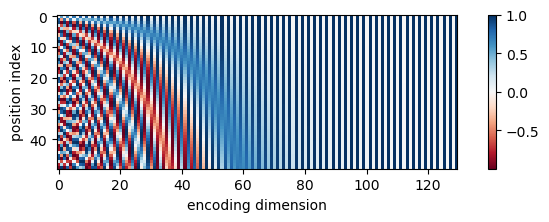

In [3]:
# visualize positional encoding as sanity check 
# confirm that matches other peoples plots - e.g., https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
import matplotlib.pyplot as plt
pos_enc = PositionalEncoder(50, 130)

plt.figure(figsize=(8,2))
plt.imshow(pos_enc(), cmap='RdBu')
plt.xlabel('encoding dimension')
plt.ylabel('position index')
plt.colorbar()
plt.show()

In [4]:
# component testing against pytorch implementations for encoder layer
pt_encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=1, dim_feedforward=2048, dropout=0, batch_first=True)
input = torch.rand(1, 8, 512)
pt_enc_out = pt_encoder_layer(input)

my_encoder_layer = EncoderLayer(512, d_k=512, d_v=512, n_heads=1, d_ff=2048) # my implementation

# transfer multiheaded attention parameters to my layer
my_encoder_layer.mha.attn[0].W_Q = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[:512, :].T) # use same parameter values
my_encoder_layer.mha.attn[0].W_K = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[512:2*512, :].T)
my_encoder_layer.mha.attn[0].W_V = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[2*512:3*512, :].T)
my_encoder_layer.mha.W_O = nn.Parameter(pt_encoder_layer.self_attn.out_proj.weight.T)

# transfer linear layer parameters to my layer
my_encoder_layer.linear1.weight = nn.Parameter(pt_encoder_layer.linear1.weight)
my_encoder_layer.linear1.bias = nn.Parameter(pt_encoder_layer.linear1.bias)

my_encoder_layer.linear2.weight = nn.Parameter(pt_encoder_layer.linear2.weight)
my_encoder_layer.linear2.bias = nn.Parameter(pt_encoder_layer.linear2.bias)

my_enc_out = my_encoder_layer(input)

assert(torch.allclose(my_enc_out, pt_enc_out, atol=1e-3, rtol=1e-3))

In [5]:
# component testing against pytorch implementations for decoder layer
# test 1 - transformer decoder without causal masking
pt_decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=1, dim_feedforward=2048, dropout=0, batch_first=True, bias=True)

memory = torch.rand(1, 8, 512)
target = torch.rand(1, 8, 512)
pt_dec_out = pt_decoder_layer(target, memory) #, tgt_mask = nn.Transformer.generate_square_subsequent_mask(8), tgt_is_causal=True)

my_decoder_layer = DecoderLayer(512, d_k=512, d_v=512, h=1, d_ff=2048) # my implementation

# transfer masked multiheaded attention parameters to my layer
my_decoder_layer.mmha.attn[0].W_Q = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[:512, :].T) # use same parameter values
my_decoder_layer.mmha.attn[0].W_K = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[512:2*512, :].T)
my_decoder_layer.mmha.attn[0].W_V = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[2*512:3*512, :].T)
my_decoder_layer.mmha.W_O = nn.Parameter(pt_decoder_layer.self_attn.out_proj.weight.T)

# transfer multiheaded attention parameters to my layer
my_decoder_layer.mha.attn[0].W_Q = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[:512, :].T) # use same parameter values
my_decoder_layer.mha.attn[0].W_K = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[512:2*512, :].T)
my_decoder_layer.mha.attn[0].W_V = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[2*512:3*512, :].T)
my_decoder_layer.mha.W_O = nn.Parameter(pt_decoder_layer.multihead_attn.out_proj.weight.T)

# transfer linear layer parameters to my layer
my_decoder_layer.linear1.weight = nn.Parameter(pt_decoder_layer.linear1.weight)
my_decoder_layer.linear1.bias = nn.Parameter(pt_decoder_layer.linear1.bias)

my_decoder_layer.linear2.weight = nn.Parameter(pt_decoder_layer.linear2.weight)
my_decoder_layer.linear2.bias = nn.Parameter(pt_decoder_layer.linear2.bias)

my_dec_out = my_decoder_layer(target, memory)

assert(torch.allclose(my_dec_out, pt_dec_out, atol=1e-3, rtol=1e-3))

# test 2 - transformer decoder with causal masking
pt_dec_out = pt_decoder_layer(target, memory, tgt_mask = nn.Transformer.generate_square_subsequent_mask(8), tgt_is_causal=True)
my_decoder_layer.mmha.attn[0].use_mask = True

my_dec_out = my_decoder_layer(target, memory)

assert(torch.allclose(my_dec_out, pt_dec_out, atol=1e-3, rtol=1e-3))

In [ ]:
# component testing against pytorch implementations for entire transformer
pt_transformer = nn.Transformer(batch_first=True, dropout=0, nhead=1)

input = torch.rand((1, 8, 512))
target = torch.rand((1, 8, 512))

pos_enc = PositionalEncoder(8, 512)

pt_out = pt_transformer(input + pos_enc(), target + + pos_enc())

my_transformer = Transformer(d_model=512, n_heads=1, seq_len = 8)

# for each encoder layer transfer parameters
for i in range(6):
    my_encoder_layer = my_transformer.encoder[i]
    pt_encoder_layer = pt_transformer.encoder.layers[i]

    my_encoder_layer.mha.attn[0].W_Q = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[:512, :].T) # use same parameter values
    my_encoder_layer.mha.attn[0].W_K = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[512:2*512, :].T)
    my_encoder_layer.mha.attn[0].W_V = nn.Parameter(pt_encoder_layer.self_attn.in_proj_weight[2*512:3*512, :].T)
    my_encoder_layer.mha.W_O = nn.Parameter(pt_encoder_layer.self_attn.out_proj.weight.T)

    # transfer linear layer parameters to my layer
    my_encoder_layer.linear1.weight = nn.Parameter(pt_encoder_layer.linear1.weight)
    my_encoder_layer.linear1.bias = nn.Parameter(pt_encoder_layer.linear1.bias)

    my_encoder_layer.linear2.weight = nn.Parameter(pt_encoder_layer.linear2.weight)
    my_encoder_layer.linear2.bias = nn.Parameter(pt_encoder_layer.linear2.bias)
    
# for each decoder layer transfer parameters
for i in range(6):
    my_decoder_layer = my_transformer.decoder[i]
    pt_decoder_layer = pt_transformer.decoder.layers[i]

    # transfer masked multiheaded attention parameters to my layer
    my_decoder_layer.mmha.attn[0].W_Q = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[:512, :].T) # use same parameter values
    my_decoder_layer.mmha.attn[0].W_K = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[512:2*512, :].T)
    my_decoder_layer.mmha.attn[0].W_V = nn.Parameter(pt_decoder_layer.self_attn.in_proj_weight[2*512:3*512, :].T)
    my_decoder_layer.mmha.W_O = nn.Parameter(pt_decoder_layer.self_attn.out_proj.weight.T)

    # transfer multiheaded attention parameters to my layer
    my_decoder_layer.mha.attn[0].W_Q = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[:512, :].T) # use same parameter values
    my_decoder_layer.mha.attn[0].W_K = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[512:2*512, :].T)
    my_decoder_layer.mha.attn[0].W_V = nn.Parameter(pt_decoder_layer.multihead_attn.in_proj_weight[2*512:3*512, :].T)
    my_decoder_layer.mha.W_O = nn.Parameter(pt_decoder_layer.multihead_attn.out_proj.weight.T)

    # transfer linear layer parameters to my layer
    my_decoder_layer.linear1.weight = nn.Parameter(pt_decoder_layer.linear1.weight)
    my_decoder_layer.linear1.bias = nn.Parameter(pt_decoder_layer.linear1.bias)

    my_decoder_layer.linear2.weight = nn.Parameter(pt_decoder_layer.linear2.weight)
    my_decoder_layer.linear2.bias = nn.Parameter(pt_decoder_layer.linear2.bias)

my_out = my_transformer(input, target)

assert torch.allclose(my_out, pt_out, atol=1e-3, rtol=1e-3)